=== PROCESO DE ENTRENAMIENTO ===
Procesando datasets...
Extrayendo características...
Calculando similitudes...
Balanceando dataset...

Entrenando Random Forest...

Evaluación en Train:
Accuracy: 0.9048
Precision: 0.8953
Recall: 0.9167
F1 Score: 0.9059


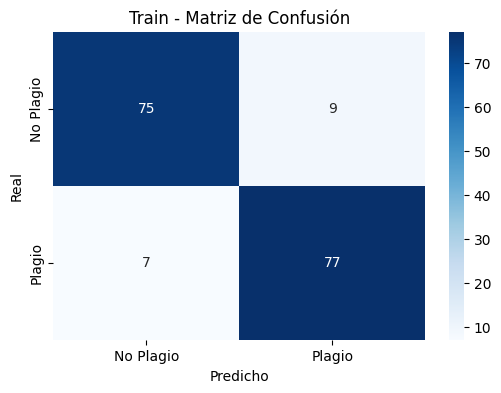


Evaluación en Test (Holdout):
Accuracy: 0.7143
Precision: 0.7368
Recall: 0.6667
F1 Score: 0.7000


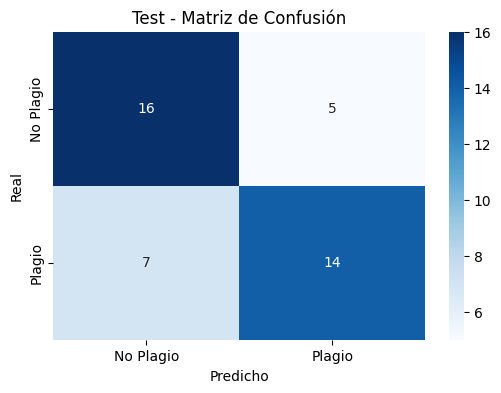


Modelo guardado en C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas\Code-Plagiarism-Detector/IR-Plag-Dataset/model

=== EVALUACIÓN EN FIRE14 TEST ===

Evaluación General en FIRE14 Test:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


c:\Users\adria\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


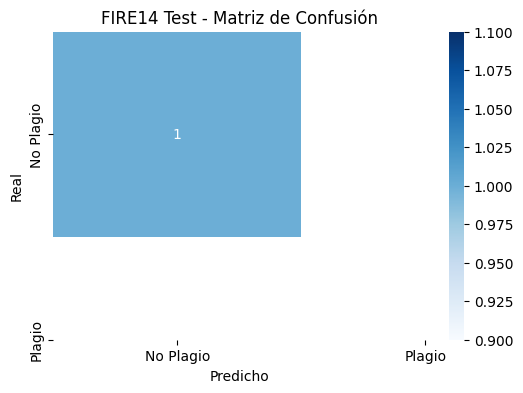


Evaluación por Escenario:

Escenario B1:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


c:\Users\adria\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


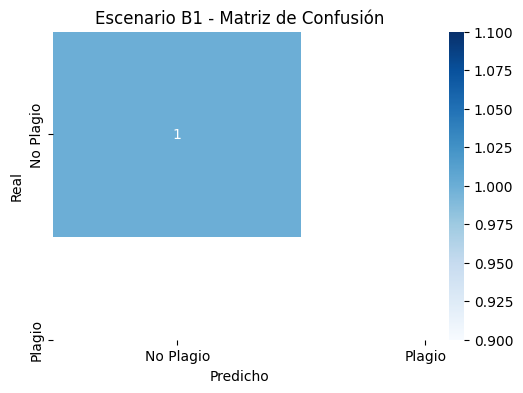

In [ ]:
import os
import pandas as pd
from pathlib import Path
import shutil
import json
import javalang
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import combinations

# ====================== CONFIGURACIÓN ======================
BASE_DIR = "C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas"
IR_PLAG_DATASET = os.path.join(BASE_DIR, "IR-Plag-Dataset/IR-Plag-Dataset")
FIRE14_TRAIN = os.path.join(BASE_DIR, "Code-Plagiarism-Detector/fire14-source-code-training-dataset")
FIRE14_TRAIN_QREL = os.path.join(FIRE14_TRAIN, "SOCO14-java.qrel")
FIRE14_TEST = os.path.join(BASE_DIR, "Code-Plagiarism-Detector/fire14-source-code-test-dataset")
FIRE14_TEST_QREL = os.path.join(FIRE14_TEST, "soco14-test-java-update.qrel")
MODEL_DIR = os.path.join(BASE_DIR, "Code-Plagiarism-Detector/IR-Plag-Dataset/model")
os.makedirs(MODEL_DIR, exist_ok=True)

# ====================== FUNCIONES COMUNES ======================
def ast_token_string(file_path):
    """Convierte un archivo Java en una cadena de tokens AST"""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            code = f.read()
        tree = javalang.parse.parse(code)
        tokens = [type(node).__name__ for path, node in tree]
        return ' '.join(tokens) if tokens else ''
    except Exception as e:
        print(f"Error parsing {file_path}: {str(e)}")
        return ''

def calculate_similarity(pair, vectorizer):
    """Calcula similitud coseno entre ASTs de dos archivos"""
    try:
        ast1 = ast_token_string(pair['file1'])
        ast2 = ast_token_string(pair['file2'])
        if not ast1 or not ast2:
            return 0
        vec1 = vectorizer.transform([ast1])
        vec2 = vectorizer.transform([ast2])
        return cosine_similarity(vec1, vec2)[0][0]
    except Exception as e:
        print(f"Error calculating similarity: {str(e)}")
        return 0

def evaluate_model(model, X, y, title="Matriz de Confusión"):
    """Evalúa el modelo y muestra métricas"""
    y_pred = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Plagio', 'Plagio'],
                yticklabels=['No Plagio', 'Plagio'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

# ====================== PROCESAMIENTO DE DATOS ======================
def process_fire14_dataset(dataset_path, qrel_path, dataset_type="train"):
    """Procesa FIRE14 (train o test) y genera pares etiquetados"""
    pairs = []
    scenarios = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'] if dataset_type == "test" else []
    
    # Procesar pares de plagio del .qrel
    with open(qrel_path, 'r') as f:
        for line in f:
            if line.strip():
                file1, file2 = line.strip().split()
                scenario = file1[:2]
                file1_path = os.path.join(dataset_path, "java", scenario, f"{file1}.java")
                file2_path = os.path.join(dataset_path, "java", scenario, f"{file2}.java")
                
                if os.path.exists(file1_path) and os.path.exists(file2_path):
                    pairs.append({
                        'file1': file1_path,
                        'file2': file2_path,
                        'label': 1,
                        'scenario': scenario
                    })
    
    # Generar pares negativos solo para testing
    if dataset_type == "test":
        for scenario in scenarios:
            scenario_dir = os.path.join(dataset_path, "java", scenario)
            if not os.path.exists(scenario_dir):
                continue
                
            files = [f.replace('.java', '') for f in os.listdir(scenario_dir) if f.endswith('.java')]
            used_files = set()
            
            for pair in pairs:
                if pair['scenario'] == scenario:
                    used_files.add(os.path.basename(pair['file1']).replace('.java', ''))
                    used_files.add(os.path.basename(pair['file2']).replace('.java', ''))
            
            unused_files = [f for f in files if f not in used_files][:20]  # Limitar para eficiencia
            
            for file1, file2 in combinations(unused_files, 2):
                file1_path = os.path.join(scenario_dir, f"{file1}.java")
                file2_path = os.path.join(scenario_dir, f"{file2}.java")
                
                pairs.append({
                    'file1': file1_path,
                    'file2': file2_path,
                    'label': 0,
                    'scenario': scenario
                })
    
    return pd.DataFrame(pairs)

def process_ir_plag_dataset(ir_plag_path):
    """Procesa el dataset IR-Plag original"""
    pairs = []
    
    for case_dir in Path(ir_plag_path).iterdir():
        if case_dir.is_dir():
            case_id = case_dir.name
            original_files = list(case_dir.glob('original/*.java'))
            
            for orig_file in original_files:
                # Pares de plagio
                for plag_file in case_dir.glob('plagiarized/**/*.java'):
                    plag_level = plag_file.parent.parent.name
                    pairs.append({
                        'file1': str(orig_file),
                        'file2': str(plag_file),
                        'label': 1,
                        'source': 'IR-Plag',
                        'plagiarism_level': plag_level.replace('L', '')
                    })
                
                # Pares no plagio
                for non_plag_file in case_dir.glob('non-plagiarized/**/*.java'):
                    pairs.append({
                        'file1': str(orig_file),
                        'file2': str(non_plag_file),
                        'label': 0,
                        'source': 'IR-Plag',
                        'plagiarism_level': None
                    })
    
    return pd.DataFrame(pairs)

# ====================== ENTRENAMIENTO ======================
def train_model():
    print("=== PROCESO DE ENTRENAMIENTO ===")
    
    # 1. Cargar y combinar datasets
    print("Procesando datasets...")
    fire14_train_df = process_fire14_dataset(FIRE14_TRAIN, FIRE14_TRAIN_QREL, "train")
    ir_plag_df = process_ir_plag_dataset(IR_PLAG_DATASET)
    combined_df = pd.concat([fire14_train_df, ir_plag_df])
    
    # 2. Extraer tokens AST y crear TF-IDF
    print("Extrayendo características...")
    all_files = set(combined_df['file1']).union(set(combined_df['file2']))
    ast_texts = [ast_token_string(file) for file in all_files]
    
    vectorizer = TfidfVectorizer()
    vectorizer.fit(ast_texts)
    
    # 3. Calcular similitudes
    print("Calculando similitudes...")
    combined_df['similarity'] = combined_df.apply(
        lambda x: calculate_similarity(x, vectorizer), axis=1)
    combined_df = combined_df[combined_df['similarity'] > 0]
    
    # 4. Balancear dataset
    print("Balanceando dataset...")
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(combined_df[['similarity']], combined_df['label'])
    balanced_df = combined_df.iloc[X_res.index]
    
    # 5. Dividir en train/test
    X = balanced_df[['similarity']]
    y = balanced_df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    
    # 6. Entrenar modelo
    print("\nEntrenando Random Forest...")
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # 7. Evaluar
    print("\nEvaluación en Train:")
    evaluate_model(model, X_train, y_train, "Train - Matriz de Confusión")
    
    print("\nEvaluación en Test (Holdout):")
    evaluate_model(model, X_test, y_test, "Test - Matriz de Confusión")
    
    # 8. Guardar modelo
    joblib.dump(model, os.path.join(MODEL_DIR, 'plagiarism_model.pkl'))
    joblib.dump(vectorizer, os.path.join(MODEL_DIR, 'vectorizer.pkl'))
    print(f"\nModelo guardado en {MODEL_DIR}")

# ====================== EVALUACIÓN EN TEST ======================
def evaluate_on_fire14_test():
    print("\n=== EVALUACIÓN EN FIRE14 TEST ===")
    
    # 1. Cargar modelo
    try:
        model = joblib.load(os.path.join(MODEL_DIR, 'plagiarism_model.pkl'))
        vectorizer = joblib.load(os.path.join(MODEL_DIR, 'vectorizer.pkl'))
    except Exception as e:
        print(f"Error cargando modelo: {str(e)}")
        return
    
    # 2. Procesar dataset de prueba
    test_df = process_fire14_dataset(FIRE14_TEST, FIRE14_TEST_QREL, "test")
    
    # 3. Calcular similitudes
    test_df['similarity'] = test_df.apply(
        lambda x: calculate_similarity(x, vectorizer), axis=1)
    test_df = test_df[test_df['similarity'] > 0]
    
    # 4. Evaluar
    X_test = test_df[['similarity']]
    y_test = test_df['label']
    
    print("\nEvaluación General en FIRE14 Test:")
    evaluate_model(model, X_test, y_test, "FIRE14 Test - Matriz de Confusión")

# ====================== EJECUCIÓN PRINCIPAL ======================
if __name__ == "__main__":
    # Entrenar modelo (comentar si ya está entrenado)
    train_model()
    
    # Evaluar en FIRE14 Test
    evaluate_on_fire14_test()